# Load

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from anndata import AnnData
from scipy.sparse import diags
from scipy.io import mmwrite
from scipy import sparse
from scipy.optimize import fsolve,minimize
from tqdm import tqdm
from pathlib import Path
from typing import Union, Optional
import pickle
import seaborn as sns

In [3]:
from scDenorm.denorm import *

In [4]:
from scAnnot.tools import *

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42

mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

# Benchmark

In [ ]:
adata=sc.read('data/pbmc3k_qc_anno.h5ad')

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.X.data

array([1., 1., 2., ..., 1., 1., 3.], dtype=float32)

## 1.Total count, Different base and pseudo count (1X2, 1X3, 2X3)

In [ ]:
cond=[
[1e3,np.e,1],
[1e4,np.e,1],
[1e5,np.e,1],
[1e6,np.e,1],
[1e4,2,1],
[1e4,10,1],
[1e4,np.e,0.01],
[1e4,np.e,0.1],
]

1000.0 2.718281828459045 1 [2.71828175 1.00000001] 8.125885749285041e-13


100%|██████████| 2638/2638 [00:15<00:00, 169.62it/s]


10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:15<00:00, 172.24it/s]


100000.0 2.718281828459045 1 [2.71828148 1.00000576] 4.954147792487245e-08


100%|██████████| 2638/2638 [00:15<00:00, 171.26it/s]


1000000.0 2.718281828459045 1 [2.7182807  1.00027606] 3.4945019540300704e-06


100%|██████████| 2638/2638 [00:15<00:00, 171.12it/s]


10000.0 2 1 [1.99999991 1.00000034] 1.1092158978989166e-10


100%|██████████| 2638/2638 [00:15<00:00, 170.58it/s]


10000.0 10 1 [10.00000404  0.99999937] 1.7950165511943375e-10


100%|██████████| 2638/2638 [00:15<00:00, 170.99it/s]


10000.0 2.718281828459045 0.01 [2.71828232 0.0099989 ] 1.0165194059978941e-10


100%|██████████| 2638/2638 [00:15<00:00, 170.63it/s]


10000.0 2.718281828459045 0.1 [2.71828206 0.0999992 ] 1.018792023645978e-10


100%|██████████| 2638/2638 [00:15<00:00, 170.88it/s]


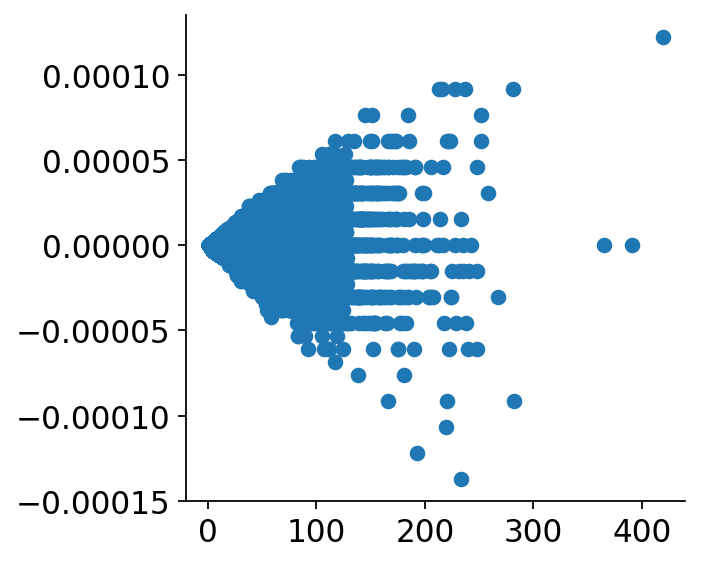

{'bodies': [<matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>,
  <matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

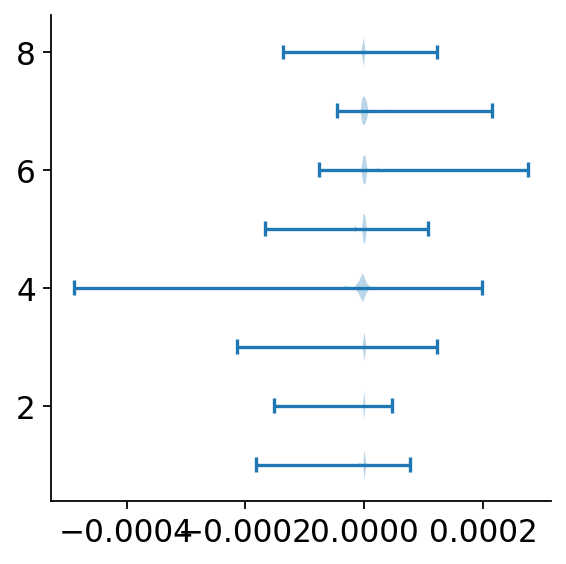

In [ ]:
rs,new_ads=[],[]
for ts,b,c in cond:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
    rs.append(res)
    new_ads.append(new_ad.copy())
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(rs,vert=False)

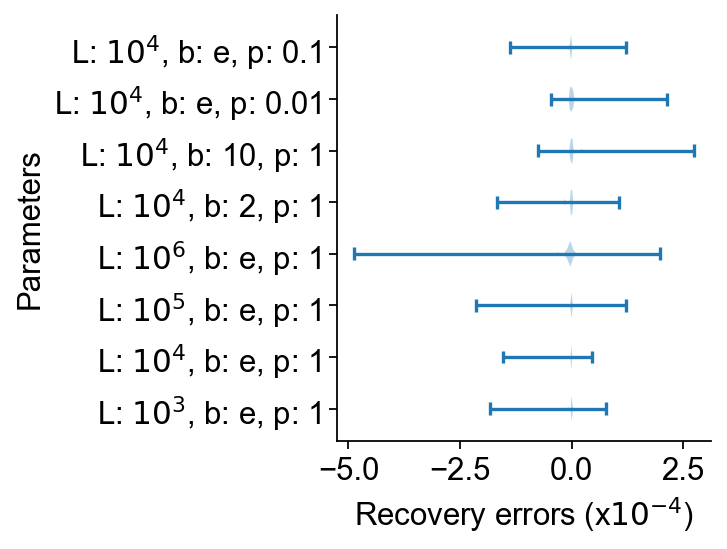

In [15]:
figsize(3,3.5)
plt.violinplot([i*10000 for i in rs],vert=False)
plt.grid(visible=False)
plt.xlabel(r'Recovery errors (x$10^{-4}$)')
plt.ylabel('Parameters')
y_ticks = range(1, len(rs) + 1)  # Generate y-tick positions
y_labels = [r'L: $10^{3}$, b: e, p: 1', r'L: $10^{4}$, b: e, p: 1', r'L: $10^{5}$, b: e, p: 1', r'L: $10^{6}$, b: e, p: 1',
            r'L: $10^{4}$, b: 2, p: 1', r'L: $10^{4}$, b: 10, p: 1', r'L: $10^{4}$, b: e, p: 0.01', r'L: $10^{4}$, b: e, p: 0.1']  # Generate y-tick labels
plt.yticks(y_ticks, y_labels)
plt.savefig('figures/method_errors.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

## floating + known base

100%|██████████| 2638/2638 [00:16<00:00, 160.33it/s]


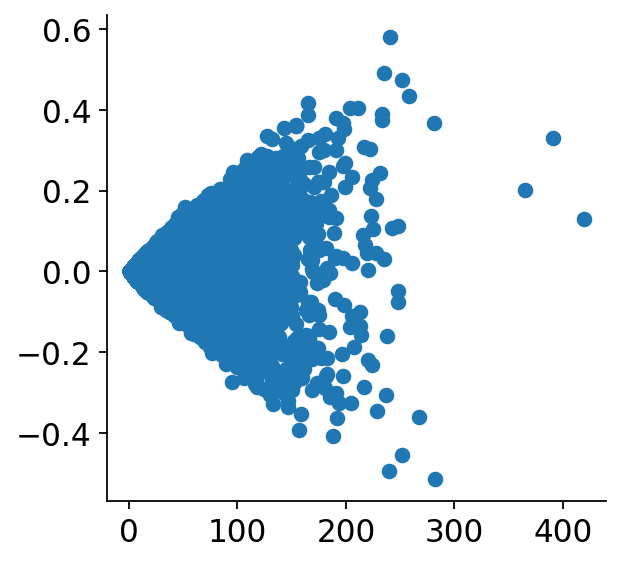

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

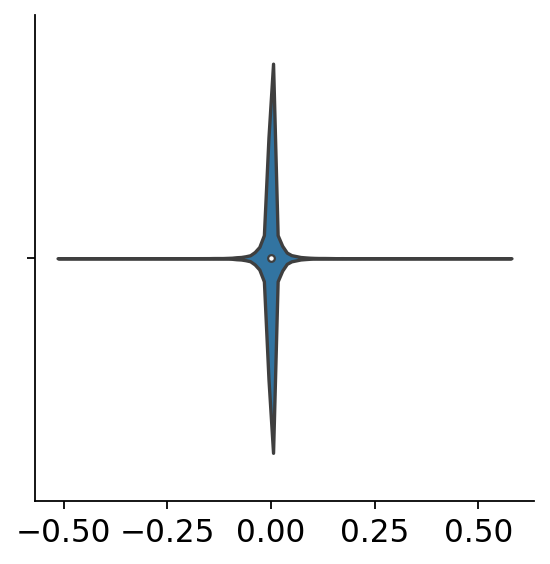

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
sns.violinplot(res)

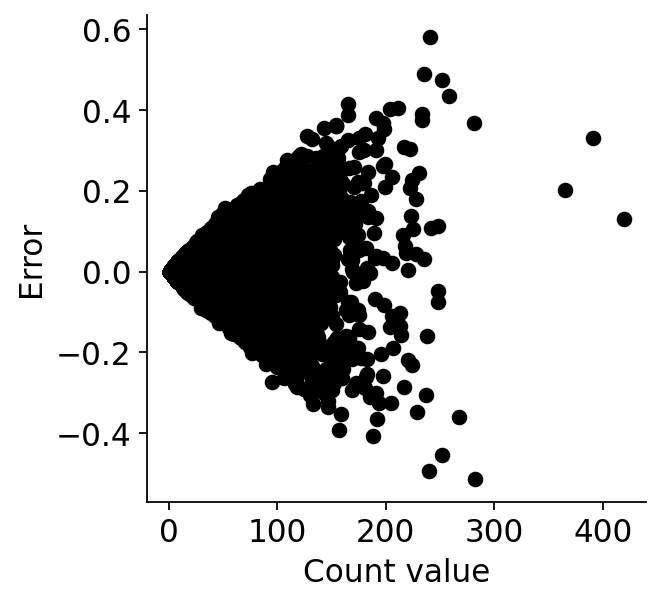

In [ ]:
figsize(4,4)
plt.plot(new_ad.layers['count'].data,res,'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count values')
plt.ylabel('Errors')
plt.savefig('figures/PBMC/rounding_errors_floating_kb.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
fk_res,fk_ad=res,new_ad

In [ ]:
(fk_res>0.5).sum()

1

In [ ]:
ad=fk_ad.copy()

[<matplotlib.lines.Line2D>]

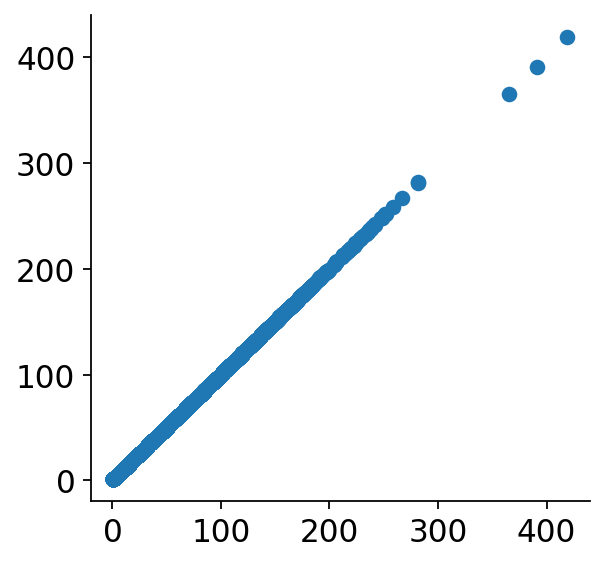

In [ ]:
plt.plot(ad.X.data,ad.layers['count'].data,'o')

## floating + auto base

10000.0 2.718281828459045 1 [2.72019642 0.99665196] 0.007728852064651502


100%|██████████| 2638/2638 [00:15<00:00, 171.41it/s]


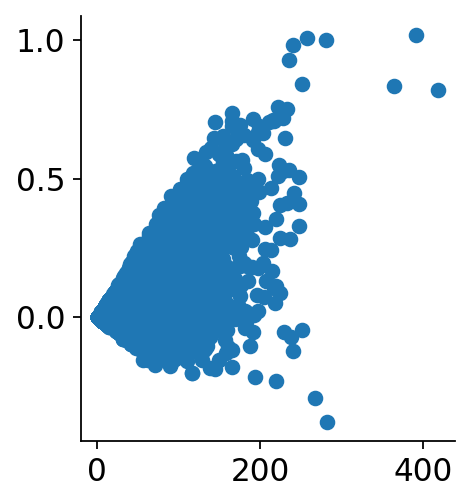

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

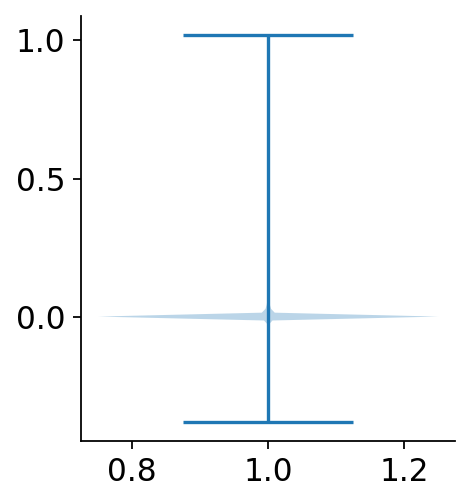

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=ad.X.data.astype(np.float16).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

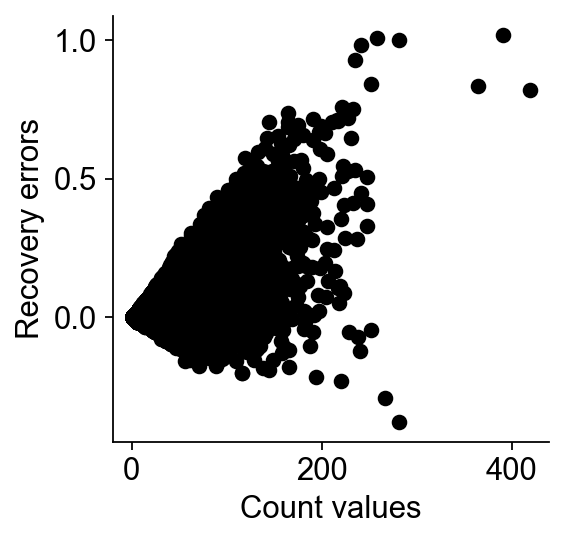

In [17]:
figsize(3.5,3.5)
plt.plot(new_ad.layers['count'].data,res,'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count values')
plt.ylabel('Recovery errors')
plt.savefig('figures/rounding_errors_floating_ad.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

In [ ]:
fa_res,fa_ad=res,new_ad.copy()

[<matplotlib.lines.Line2D>]

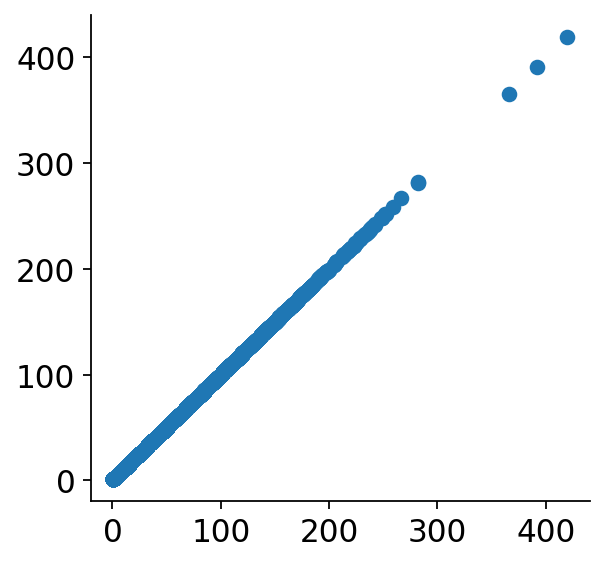

In [ ]:
ad=fa_ad.copy()
plt.plot(ad.X.data,ad.layers['count'].data,'o')

In [ ]:
fa_ad.X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Column format>

In [ ]:
(fa_res>0.5).sum()

69

## HVG + auto base

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:05<00:00, 518.78it/s]


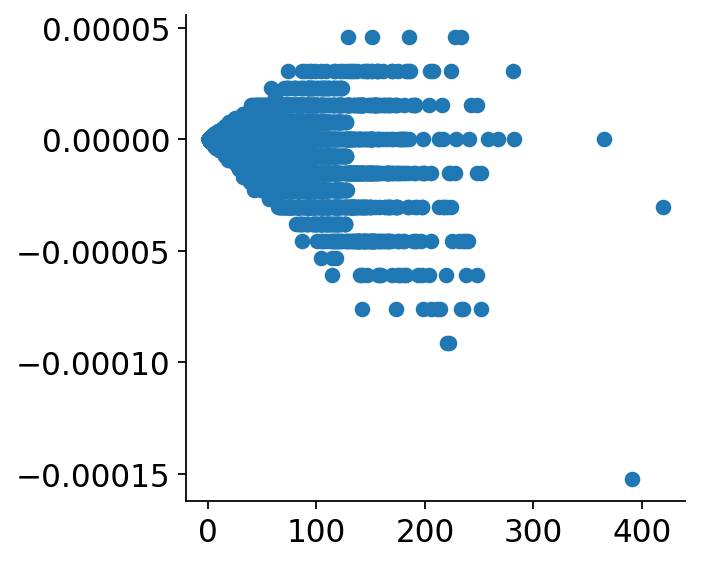

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

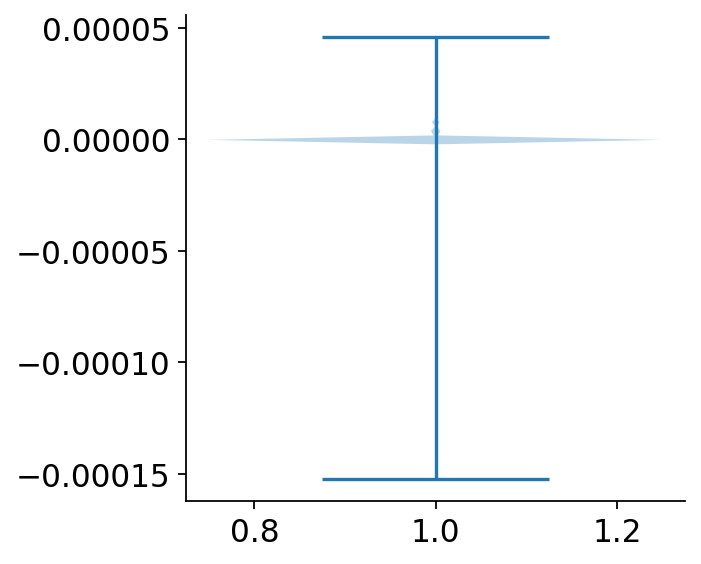

In [ ]:
for ts,b,c in [[1e4,np.e,1]]:
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    sc.pp.highly_variable_genes(ad,layer='count', n_top_genes=2000,flavor='seurat_v3')
    ad = ad[:, ad.var.highly_variable]
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
        
plt.plot(new_ad.layers['count'].data,res,'o')
plt.show()
plt.violinplot(res,vert=True)

In [ ]:
hvg_res,hvg_ad=res,new_ad

In [ ]:
(hvg_res>0.5).sum()

0

[<matplotlib.lines.Line2D>]

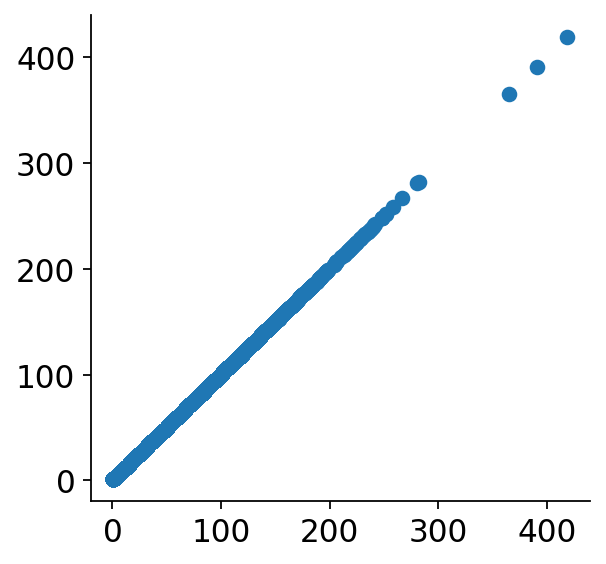

In [ ]:
ad=hvg_ad.copy()
plt.plot(ad.X.data,ad.layers['count'].data,'o')

### save

In [ ]:
with open(f'data/pbmc3k_qc_anno_results.pickle', 'wb') as handle:
    pickle.dump([[rs,new_ads],[fk_res,fk_ad],[fa_res,fa_ad],[hvg_res,hvg_ad]], handle, protocol=pickle.HIGHEST_PROTOCOL)

## UMAP

In [ ]:
ad=adata.copy()
ad.obs['group']='Origin'

In [ ]:
hvg_ad.obs['group']='HVG'
fa_ad.obs['group']='Floating'

In [ ]:
hvg_ad

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [ ]:
ad=ad.concatenate([fa_ad,hvg_ad])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad

AnnData object with n_obs × n_vars = 7914 × 2000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'group', 'batch'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'dispersions', 'dispersions_norm', 'highly_variable-0', 'means-0', 'highly_variable-1', 'means-1', 'highly_variable-2', 'means-2', 'highly_variable_rank-2', 'variances-2', 'variances_norm-2'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'

In [ ]:
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

In [ ]:
sc.tl.pca(ad, svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(ad,n_neighbors=10, n_pcs=40)
sc.tl.umap(ad)

In [ ]:
ad.obs['group']=ad.obs['group'].cat.reorder_categories(['Origin','Floating','HVG'])

In [ ]:
ad.uns['leiden_colors']=['#5C89CC', '#FFB6C1', '#D9C566', '#FF8011', '#9440F3', '#E30B5C', '#AFE1AF', '#74caff']

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


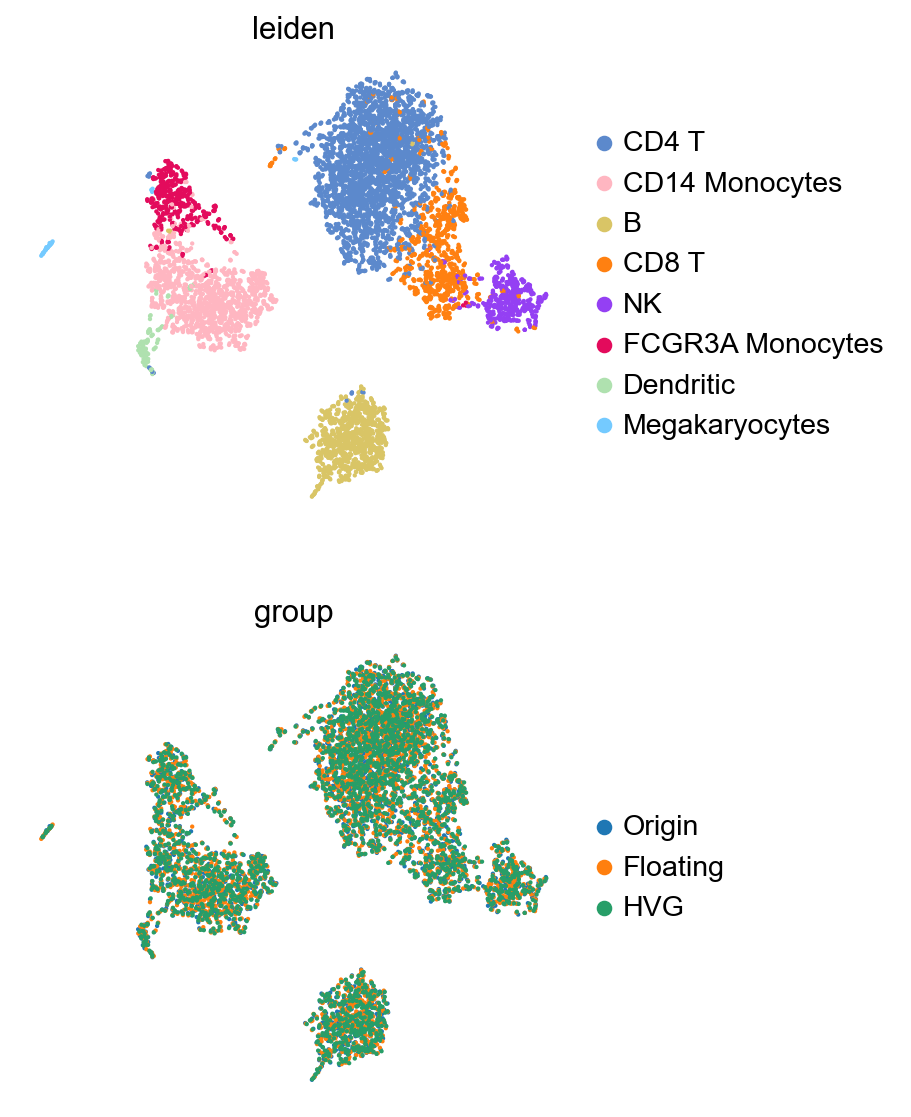

In [7]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden','group'],frameon=False,ncols=1,save='pbmc3k_benchmark0.pdf')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


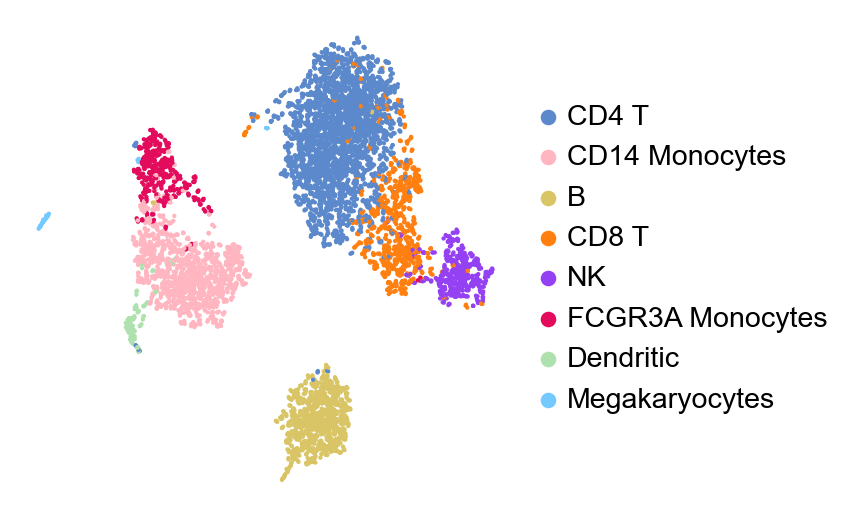

In [8]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden'],frameon=False,ncols=1,title='',save='pbmc3k_benchmark1.pdf')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


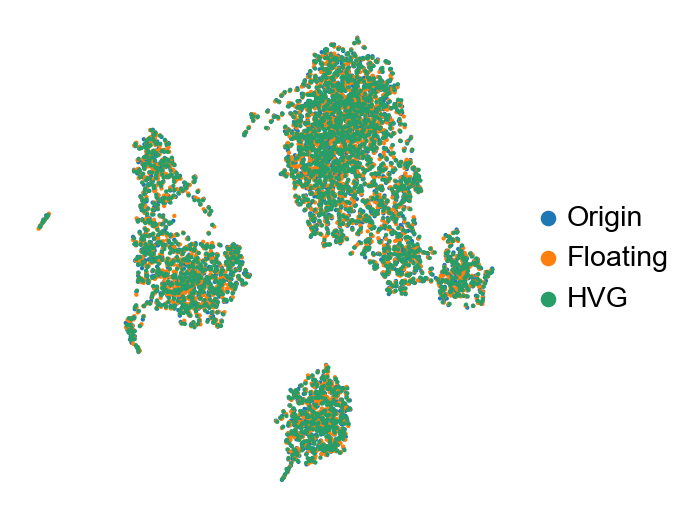

In [9]:
figsize(4,4)
sc.pl.umap(ad, color=['group'],frameon=False,ncols=1,title='',save='pbmc3k_benchmark2.pdf')

In [ ]:
ad.write_h5ad('data/pbmc3k_benchmark.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


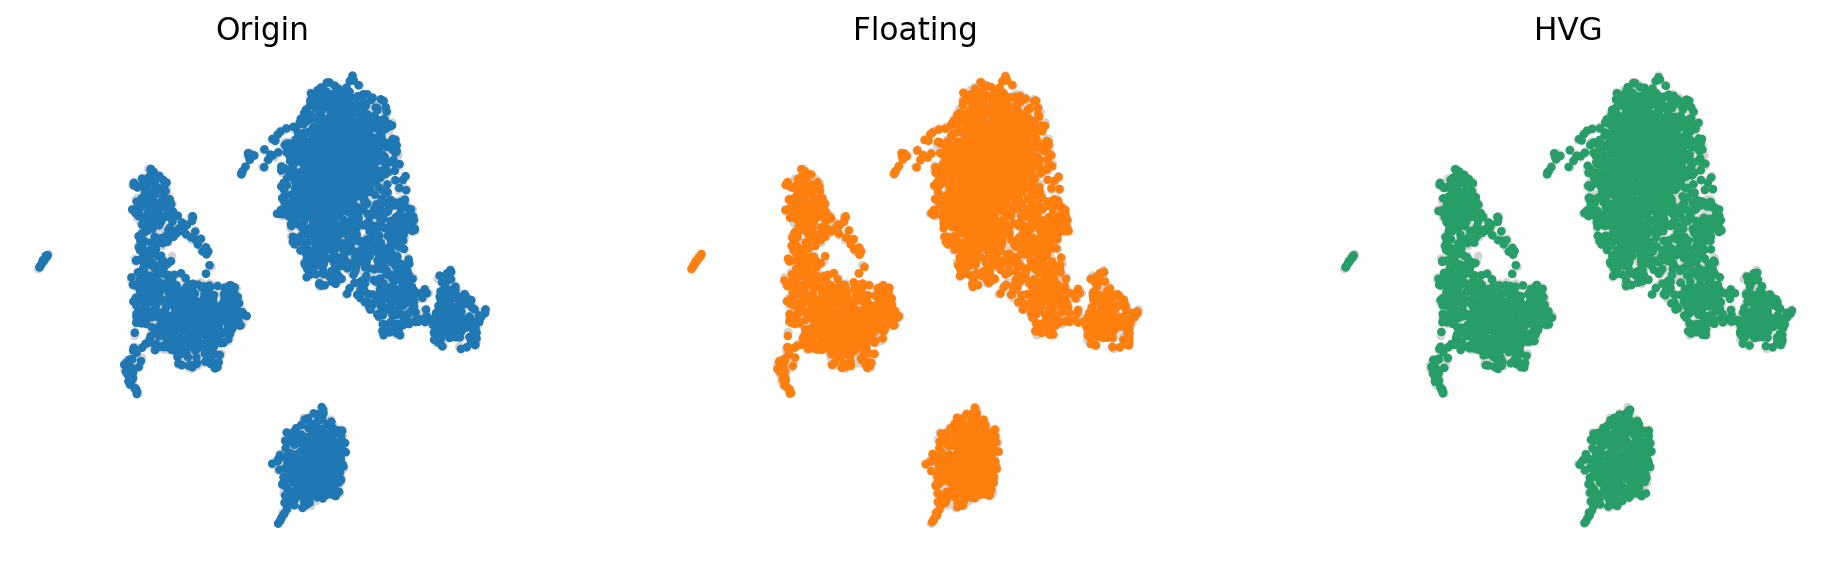

In [ ]:
cluster_small_multiples(ad,'group',save='pbmc3k_benchmark.pdf')

# rounds the elements of an array to the specified number of decimal places

In [18]:
adata=sc.read('data/pbmc3k_qc_anno.h5ad')
adata.X=adata.layers['count'].copy()

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [19]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count', 'norm'
    obsp: 'connectivities', 'distances'

In [20]:
ad.X.data

array([3.1137543, 3.7844338, 3.1137543, ..., 3.367682 , 3.367682 ,
       3.367682 ], dtype=float32)

10000.0 2.718281828459045 1 [2.73124569 0.9855368 ] 0.27334814159517185


100%|██████████| 2638/2638 [00:01<00:00, 1896.27it/s]


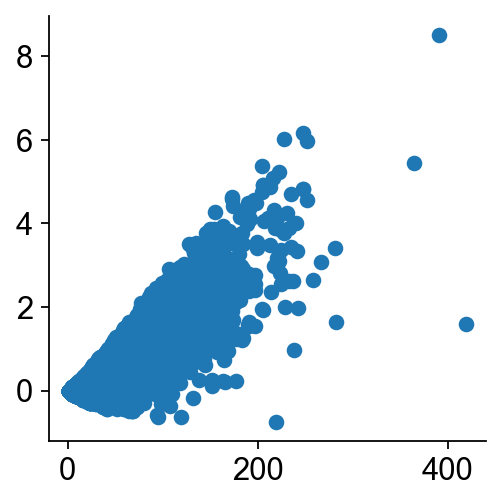

10000.0 2.718281828459045 1 [2.71858521 0.99949668] 0.0019235858450211635


100%|██████████| 2638/2638 [00:01<00:00, 1921.34it/s]


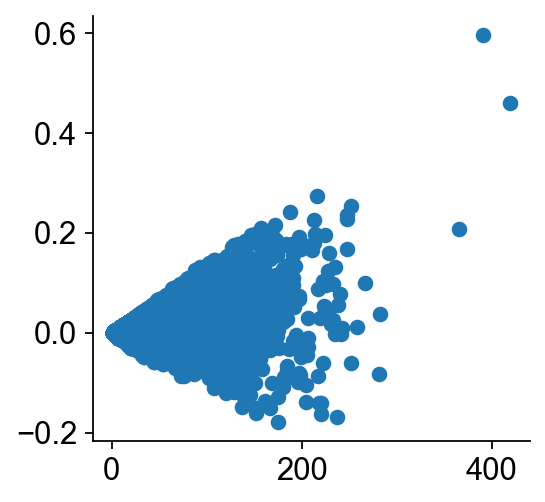

10000.0 2.718281828459045 1 [2.71814632 1.00029789] 2.569164148136118e-05


100%|██████████| 2638/2638 [00:01<00:00, 2086.69it/s]


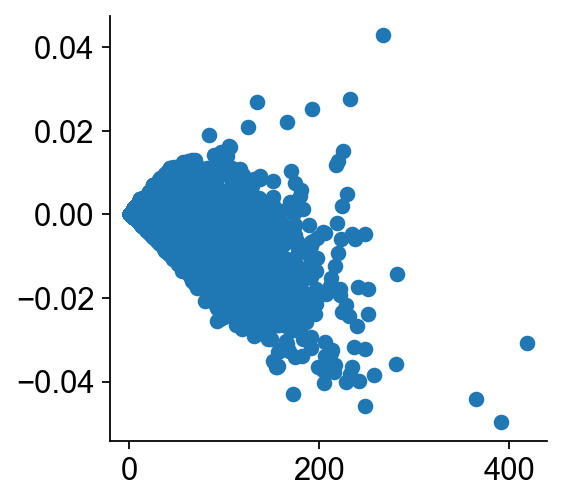

10000.0 2.718281828459045 1 [2.71827667 1.00000452] 2.335881042087131e-07


100%|██████████| 2638/2638 [00:01<00:00, 2103.98it/s]


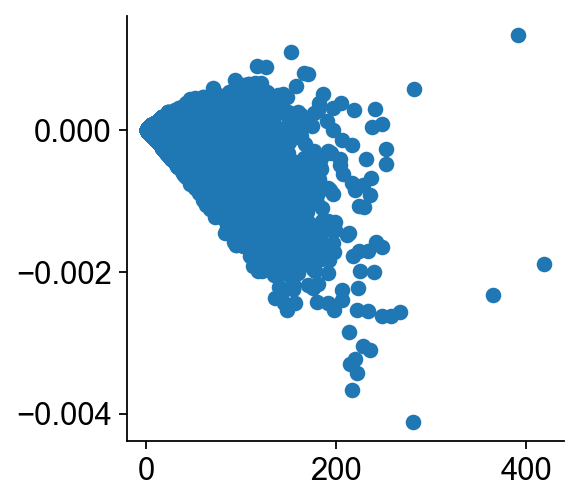

10000.0 2.718281828459045 1 [2.71827978 1.00000282] 2.158986341779521e-09


100%|██████████| 2638/2638 [00:01<00:00, 1972.10it/s]


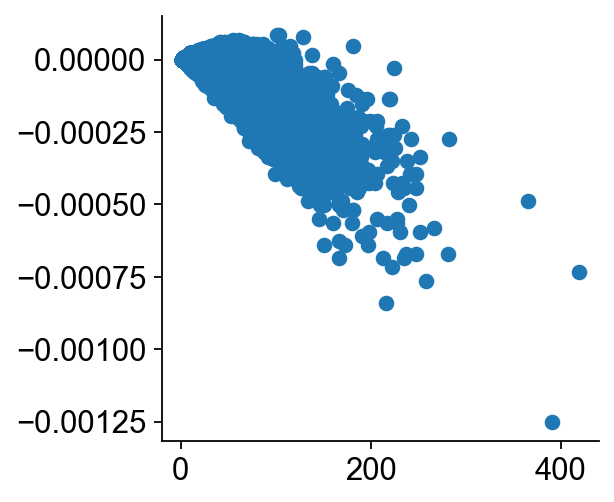

10000.0 2.718281828459045 1 [2.7182814  1.00000068] 1.7284746132698318e-10


100%|██████████| 2638/2638 [00:02<00:00, 1178.15it/s]


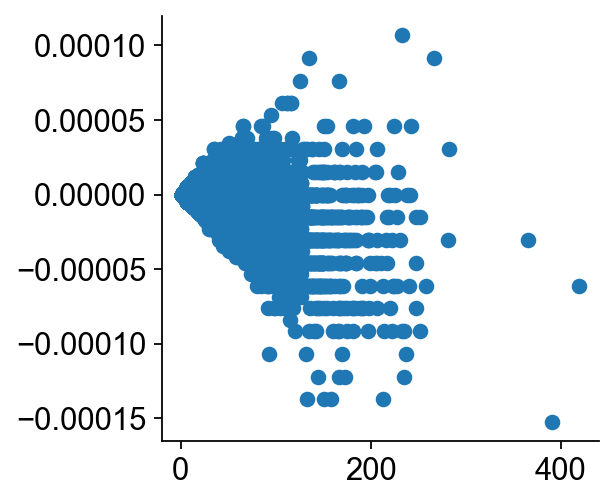

10000.0 2.718281828459045 1 [2.71828198 0.99999972] 2.870344344224059e-10


100%|██████████| 2638/2638 [00:01<00:00, 2077.28it/s]


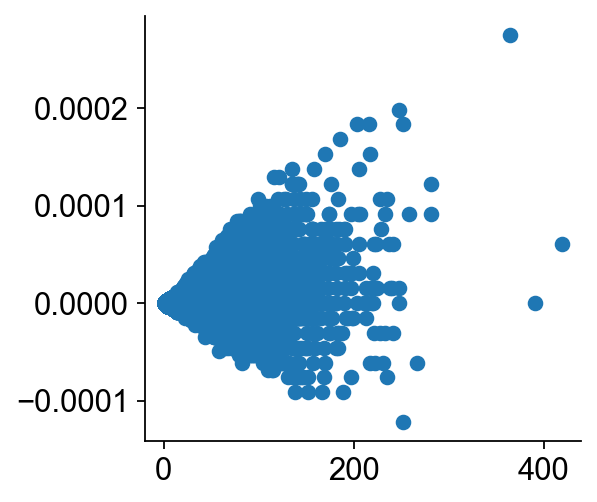

{'bodies': [<matplotlib.collections.PolyCollection at 0x2b05829e0760>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2b05829e0820>,
 'cmins': <matplotlib.collections.LineCollection at 0x2b0582a761c0>,
 'cbars': <matplotlib.collections.LineCollection at 0x2b0582a76f70>}

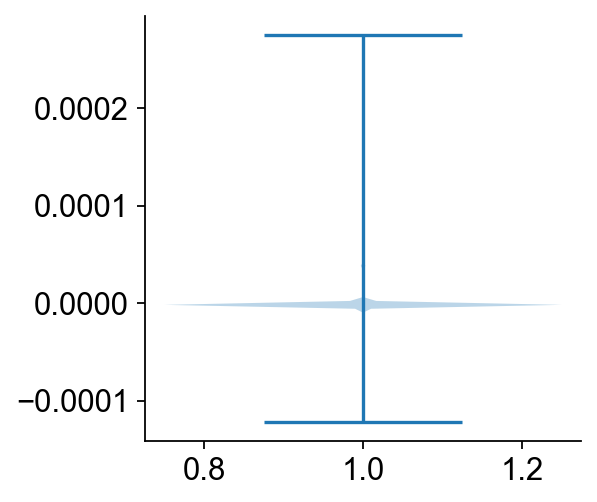

In [21]:
dp_res,dp_ad,dp_para=[],[],[]
for k in range(2,9):
    ts,b,c=[1e4,np.e,1]
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    ad.X.data=np.around(ad.X.data, decimals=k).astype(np.float32)
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    dp_para.append([b,c,res.fun])
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
        plt.plot(new_ad.layers['count'].data,res,'o')
        plt.show()
    else:
        raise('index not match')
    dp_res.append(res)
    dp_ad.append(new_ad.copy())
plt.violinplot(res,vert=True)

In [22]:
dp_res

[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]

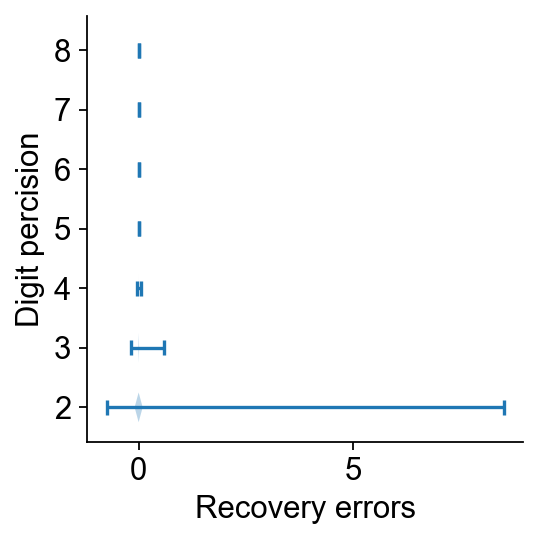

In [24]:
figsize(3.5,3.5)
plt.violinplot(dp_res,vert=False)
plt.grid(visible=False)
plt.xlabel('Recovery errors')
plt.ylabel('Digit percision')
y_ticks = range(1, len(dp_res) + 1)  # Generate y-tick positions
y_labels = [i+1 for i in y_ticks]  # Generate y-tick labels
plt.yticks(y_ticks, y_labels)
plt.savefig('figures/digit_precision_errors.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

Text(0, 0.5, 'Error')

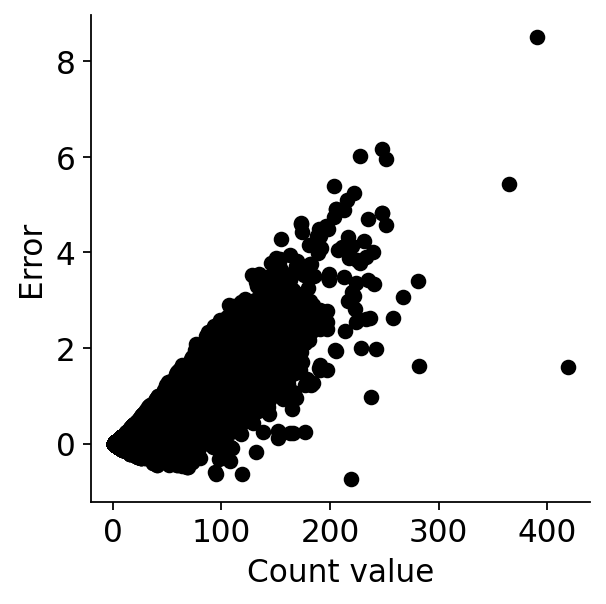

In [ ]:
figsize(4,4)
plt.plot(dp_ad[0].layers['count'].data,dp_res[0],'o',c='black')
plt.grid(visible=False)
plt.xlabel('Count value')
plt.ylabel('Error')
#plt.savefig('figures/PBMC/rounding_errors_floating_ad.pdf',dpi=300, bbox_inches='tight',transparent=True)

In [ ]:
dp_para

[[2.731245684555231, 0.9855368064078, 0.273348141595169],
 [2.718585212615867, 0.9994966790017392, 0.0019235858450206299],
 [2.7181463182923307, 1.0002978865773906, 2.5691641481452587e-05],
 [2.7182766747331377, 1.0000045171435494, 2.335881042041391e-07],
 [2.718279783852874, 1.0000028171345348, 2.1589863414209206e-09],
 [2.7182813994639896, 1.0000006794127998, 1.7284746107388254e-10],
 [2.718281984401084, 0.999999723656416, 2.870344342155565e-10]]

In [ ]:
dp_para=pd.DataFrame(dp_para,columns=['b','c','mse'])

In [ ]:
dp_para['dp']=range(2,9)
dp_para['dp']=dp_para['dp'].astype(str).astype('category')

In [ ]:
dp_para['dp']=dp_para['dp'].cat.reorder_categories(['2', '3', '4', '5', '6', '7', '8'][::-1])

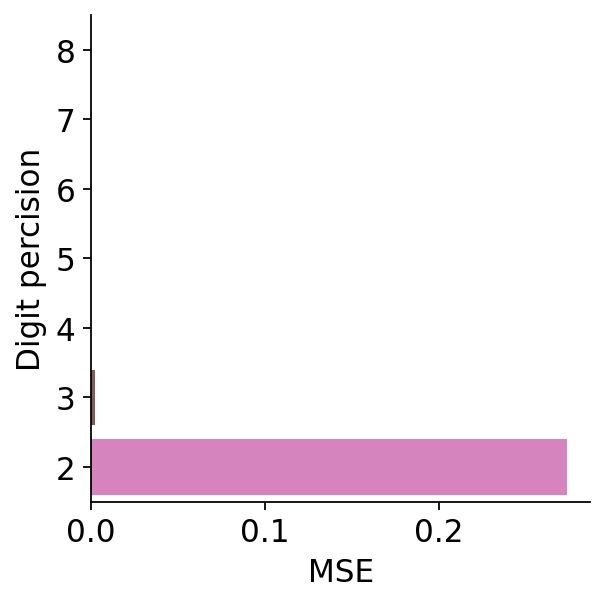

In [ ]:
figsize(4,4)
sns.barplot(y='dp',x='mse',data=dp_para)
plt.grid(visible=False)
plt.xlabel('MSE')
plt.ylabel('Digit percision')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/PBMC/DP_MSE.pdf',dpi=300, bbox_inches='tight',transparent=True)

## UMAP

In [ ]:
ad=adata.copy()

In [ ]:
ad=ad.concatenate(dp_ad[:2])

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
ad.obs.batch

index
AAACATACAACCAC-1-0    0
AAACATTGAGCTAC-1-0    0
AAACATTGATCAGC-1-0    0
AAACCGTGCTTCCG-1-0    0
AAACCGTGTATGCG-1-0    0
                     ..
TTTCGAACTCTCAT-1-2    2
TTTCTACTGAGGCA-1-2    2
TTTCTACTTCCTCG-1-2    2
TTTGCATGAGAGGC-1-2    2
TTTGCATGCCTCAC-1-2    2
Name: batch, Length: 7914, dtype: category
Categories (3, object): ['0', '1', '2']

In [ ]:
ad.X.data

array([1.     , 1.     , 2.     , ..., 1.     , 1.     , 3.00133],
      dtype=float32)

In [ ]:
sc.pp.normalize_total(ad, target_sum=1e4)
sc.pp.log1p(ad)

In [ ]:
sc.tl.pca(ad, svd_solver='arpack',use_highly_variable=False)
sc.pp.neighbors(ad)
sc.tl.umap(ad)

In [ ]:
ad.obs['batch']=ad.obs.batch.replace({'0': 'Origin', '1': '2-DP','2':'3-DP'})

In [ ]:
ad.uns['leiden_colors']=['#5C89CC', '#FFB6C1', '#D9C566', '#FF8011', '#9440F3', '#E30B5C', '#AFE1AF', '#74caff']

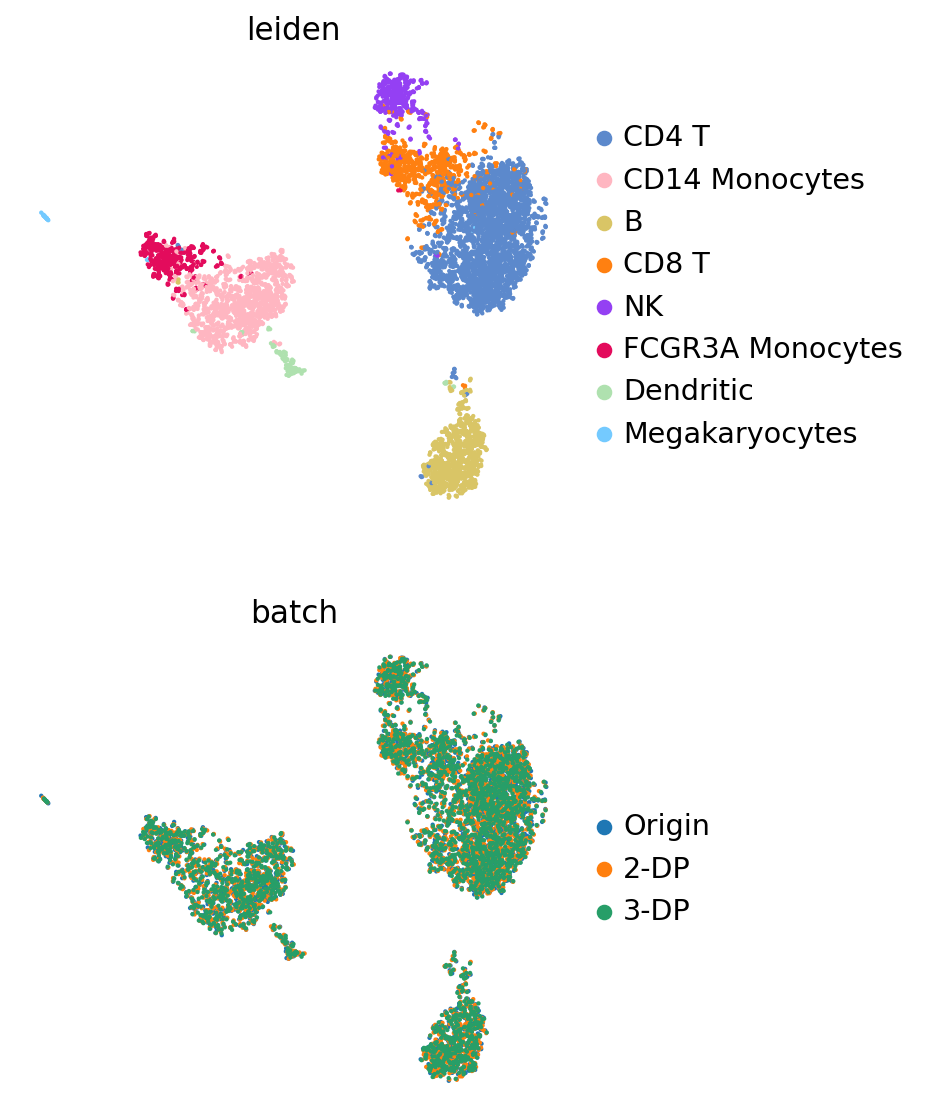

In [ ]:
figsize(4,4)
sc.pl.umap(ad, color=['leiden','batch'],frameon=False,ncols=1,save='pbmc3k_DP.pdf')

In [ ]:
ad.write_h5ad('data/pbmc3k_DP.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


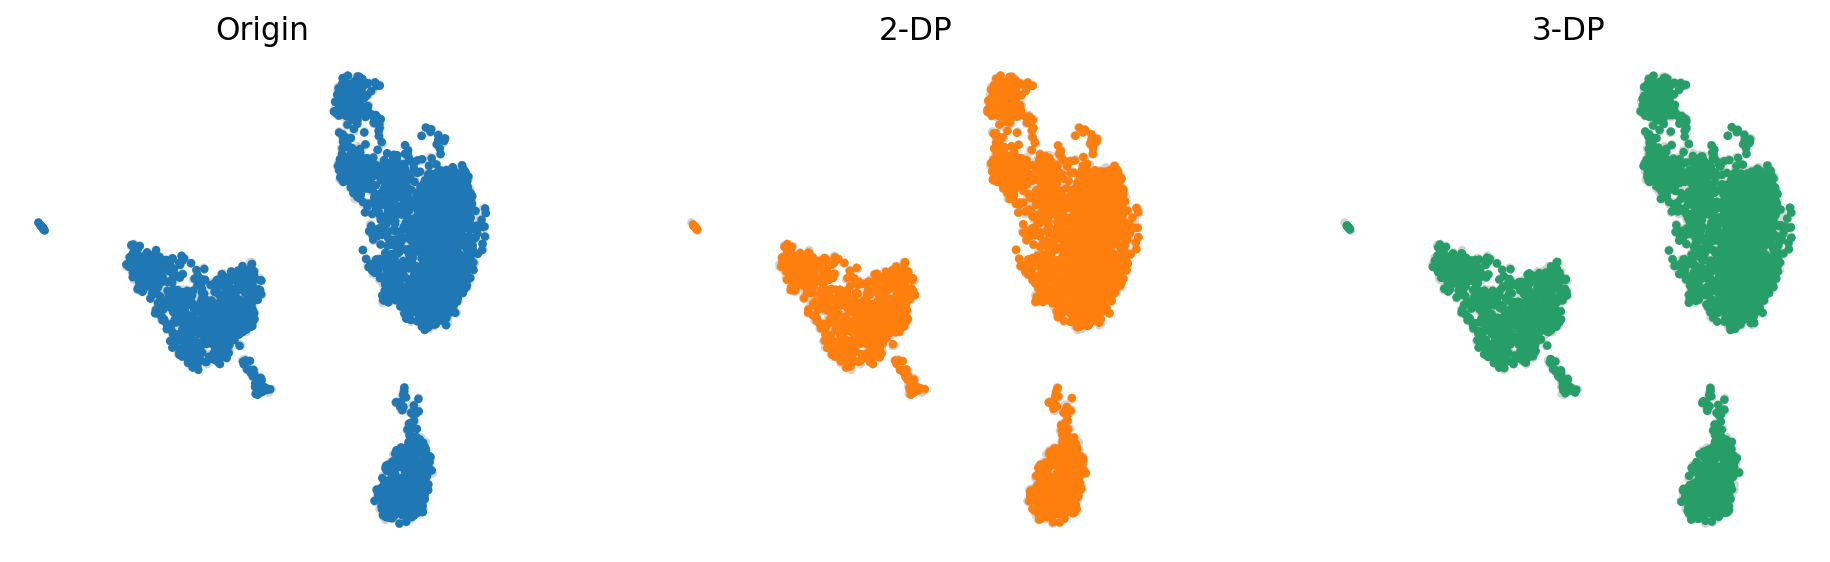

In [ ]:
cluster_small_multiples(ad,'batch',save='pbmc3k_DP_sep.pdf')

# How many HVG
- from 5000 -> 100

10000.0 2.718281828459045 1 [1.9       1.1576178] 132.07318990525653


100%|██████████| 2638/2638 [00:02<00:00, 1300.95it/s]


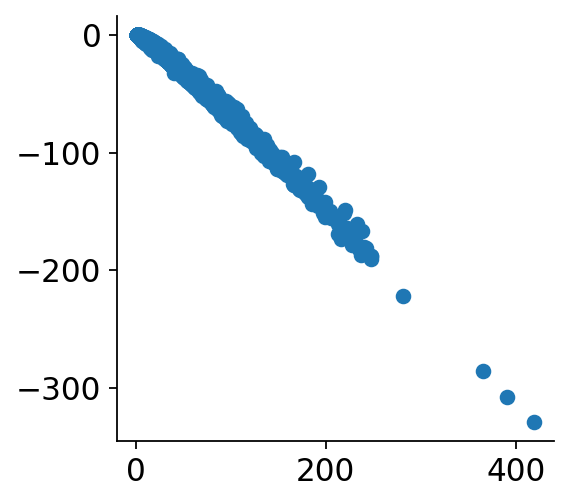

10000.0 2.718281828459045 1 [1.9        1.44055251] 66.4146305146886


100%|██████████| 2638/2638 [00:02<00:00, 1183.36it/s]


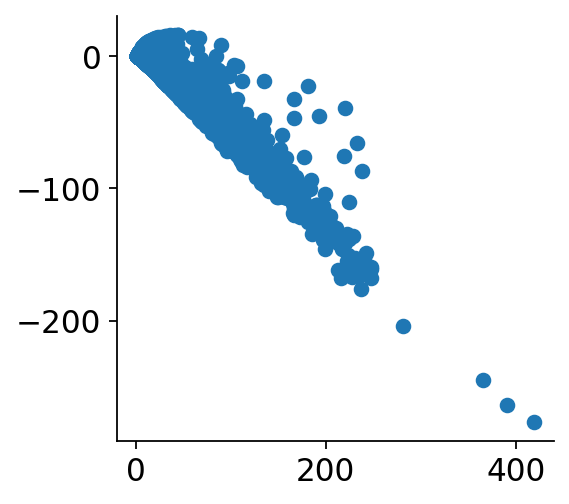

10000.0 2.718281828459045 1 [1.9        1.60834323] 11.748769428720092


100%|██████████| 2638/2638 [00:02<00:00, 1059.73it/s]


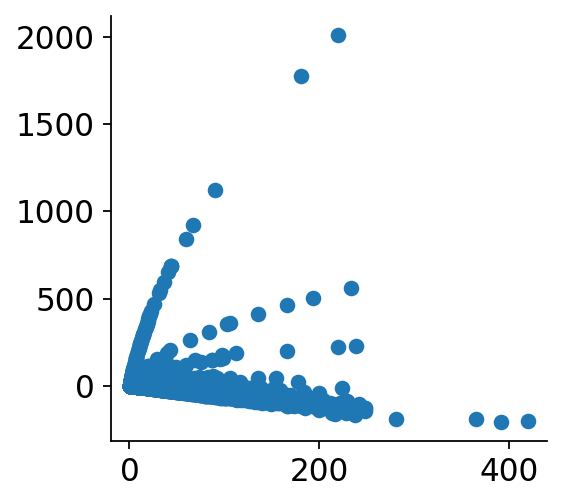

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:02<00:00, 961.62it/s]


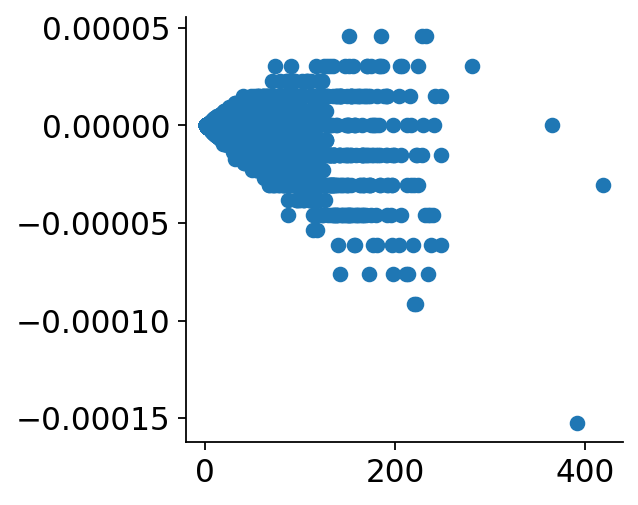

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:02<00:00, 887.46it/s]


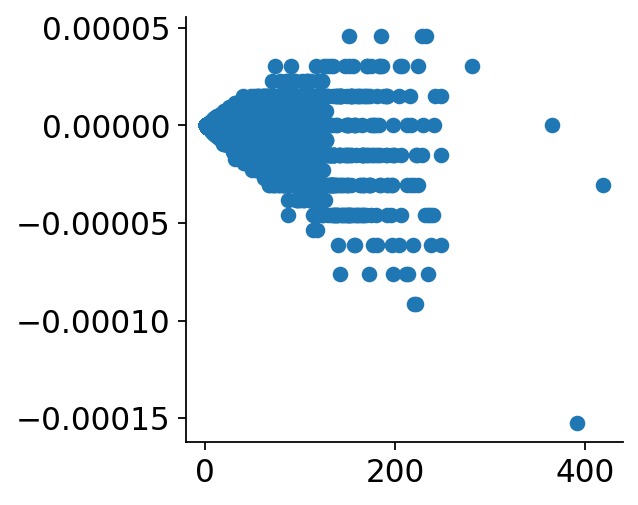

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:03<00:00, 731.63it/s]


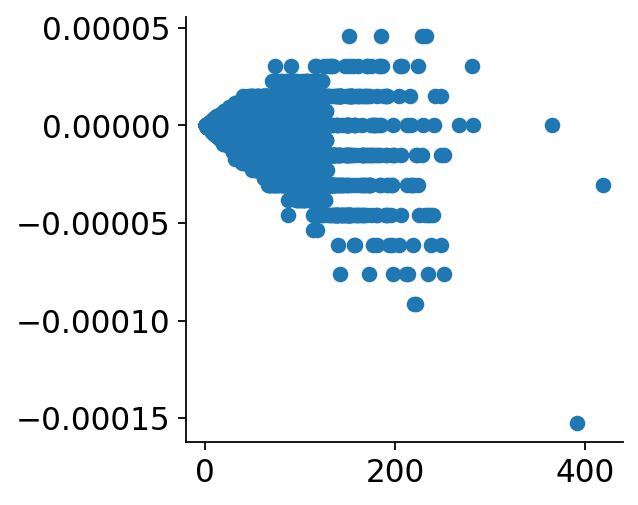

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:05<00:00, 523.54it/s]


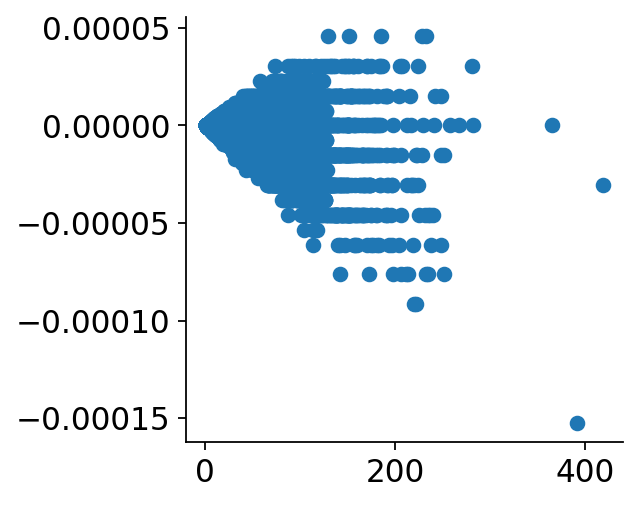

10000.0 2.718281828459045 1 [2.71828179 1.00000006] 7.96892254064206e-11


100%|██████████| 2638/2638 [00:06<00:00, 377.95it/s]


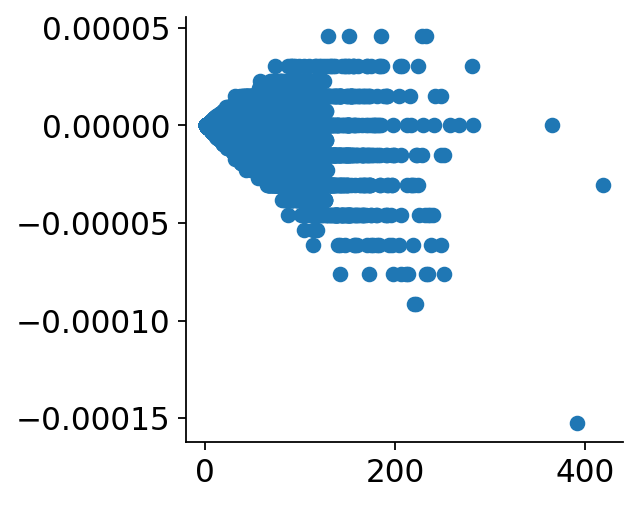

{'bodies': [<matplotlib.collections.PolyCollection>],
 'cmaxes': <matplotlib.collections.LineCollection>,
 'cmins': <matplotlib.collections.LineCollection>,
 'cbars': <matplotlib.collections.LineCollection>}

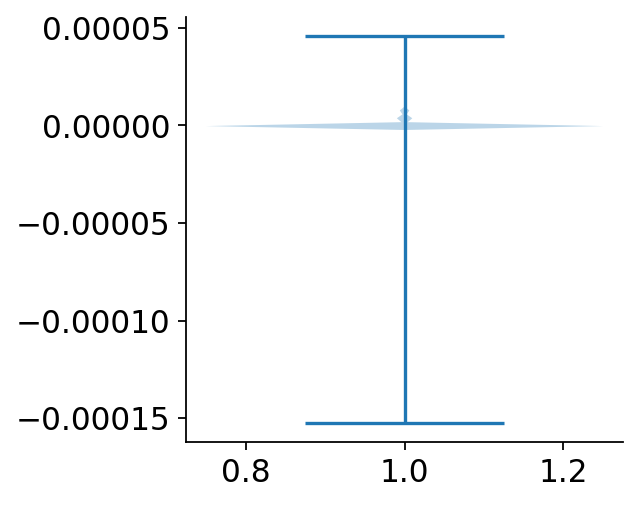

In [ ]:
hh_res,hh_ad,hh_para=[],[],[]
for n in [100,200,300,400,500,1000,2000,5000]:
    ts,b,c=[1e4,np.e,1]
    ad=adata.copy()
    ad.X=sparse.csc_matrix(ad.X)
    ad.layers['count']=ad.X.copy()
    sc.pp.normalize_total(ad, target_sum=ts)
    ad.X.data=np.log(ad.X.data+c) / np.log(b)
    #sc.pp.log1p(ad,base=b)
    sc.pp.highly_variable_genes(ad,layer='count', n_top_genes=n,flavor='seurat_v3')
    ad = ad[:, ad.var.highly_variable]
    #auto solve
    smtx2=ad.X
    np.random.seed(0)
    ys=[]
    for c_idx in np.random.choice(range(smtx2.shape[0]),min(smtx2.shape[0],100),replace=False):
        try:
            r = pd.Series(smtx2.getrow(c_idx).data)
            y = np.array(r.value_counts().sort_index().head(2).index)
            ys.append(y)
        except:
            print(c_idx)
    ys=np.array(ys)
    y1=ys[:,0]
    y2=ys[:,1]
    res = minimize(solve_bc, [20,1], method='L-BFGS-B', tol=1e-10,bounds=[(1.9, None), (1e-6, None)],args=(ys[:,0],ys[:,1]))
    print(ts,b,c,res.x,res.fun)
    b,c=res.x
    hh_para.append([b,c,res.fun])
    new_ad=scdenorm(ad,base=b,cont=c,cutoff=0.5,rint=False)
    new_ad.X=sparse.csc_matrix(new_ad.X)
    if np.array_equal(ad.X.indices, new_ad.X.indices) and np.array_equal(ad.X.indptr, new_ad.X.indptr):
        res=new_ad.X.data-new_ad.layers['count'].data
    else:
        raise('index not match')
    hh_res.append(res)
    hh_ad.append(new_ad)
    plt.plot(new_ad.layers['count'].data,res,'o')
    plt.show()
plt.violinplot(res,vert=True)

In [26]:
hh_para=pd.DataFrame(hh_para,columns=['b','c','mse'])

In [ ]:
hh_para['hvg']=[100,200,300,400,500,1000,2000,5000]
hh_para['hvg']=hh_para['hvg'].astype(str).astype('category')

In [ ]:
hh_para['hvg']=hh_para['hvg'].cat.reorder_categories(['100', '200','300', '400', '500','1000', '2000', '5000'][::-1])

In [ ]:
hh_para

,b,c,mse,hvg
0,1.900000,1.157618,1.320732e+02,100
1,1.900000,1.440553,6.641463e+01,200
2,1.900000,1.608343,1.174877e+01,300
3,2.718282,1.000000,7.968923e-11,400
4,2.718282,1.000000,7.968923e-11,500
5,2.718282,1.000000,7.968923e-11,1000
6,2.718282,1.000000,7.968923e-11,2000
7,2.718282,1.000000,7.968923e-11,5000


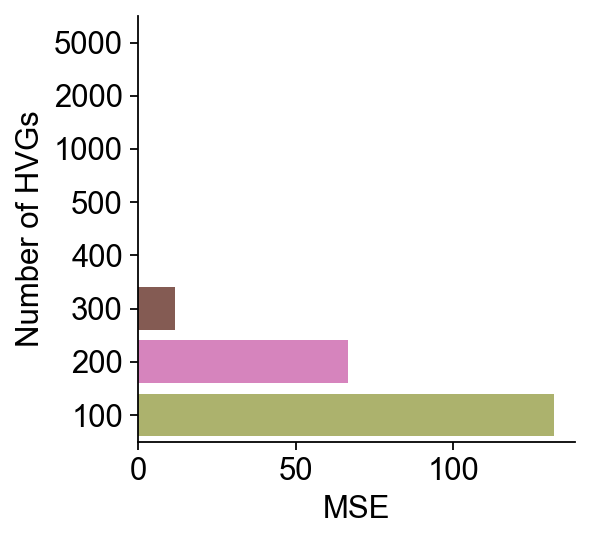

In [41]:
figsize(3.5,3.5)
sns.barplot(y='hvg',x='mse',data=hh_para)
plt.grid(visible=False)
plt.xlabel('MSE')
plt.ylabel('Number of HVGs')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('figures/HVG_MSE.pdf',dpi=300, bbox_inches='tight',transparent=True,format='pdf')

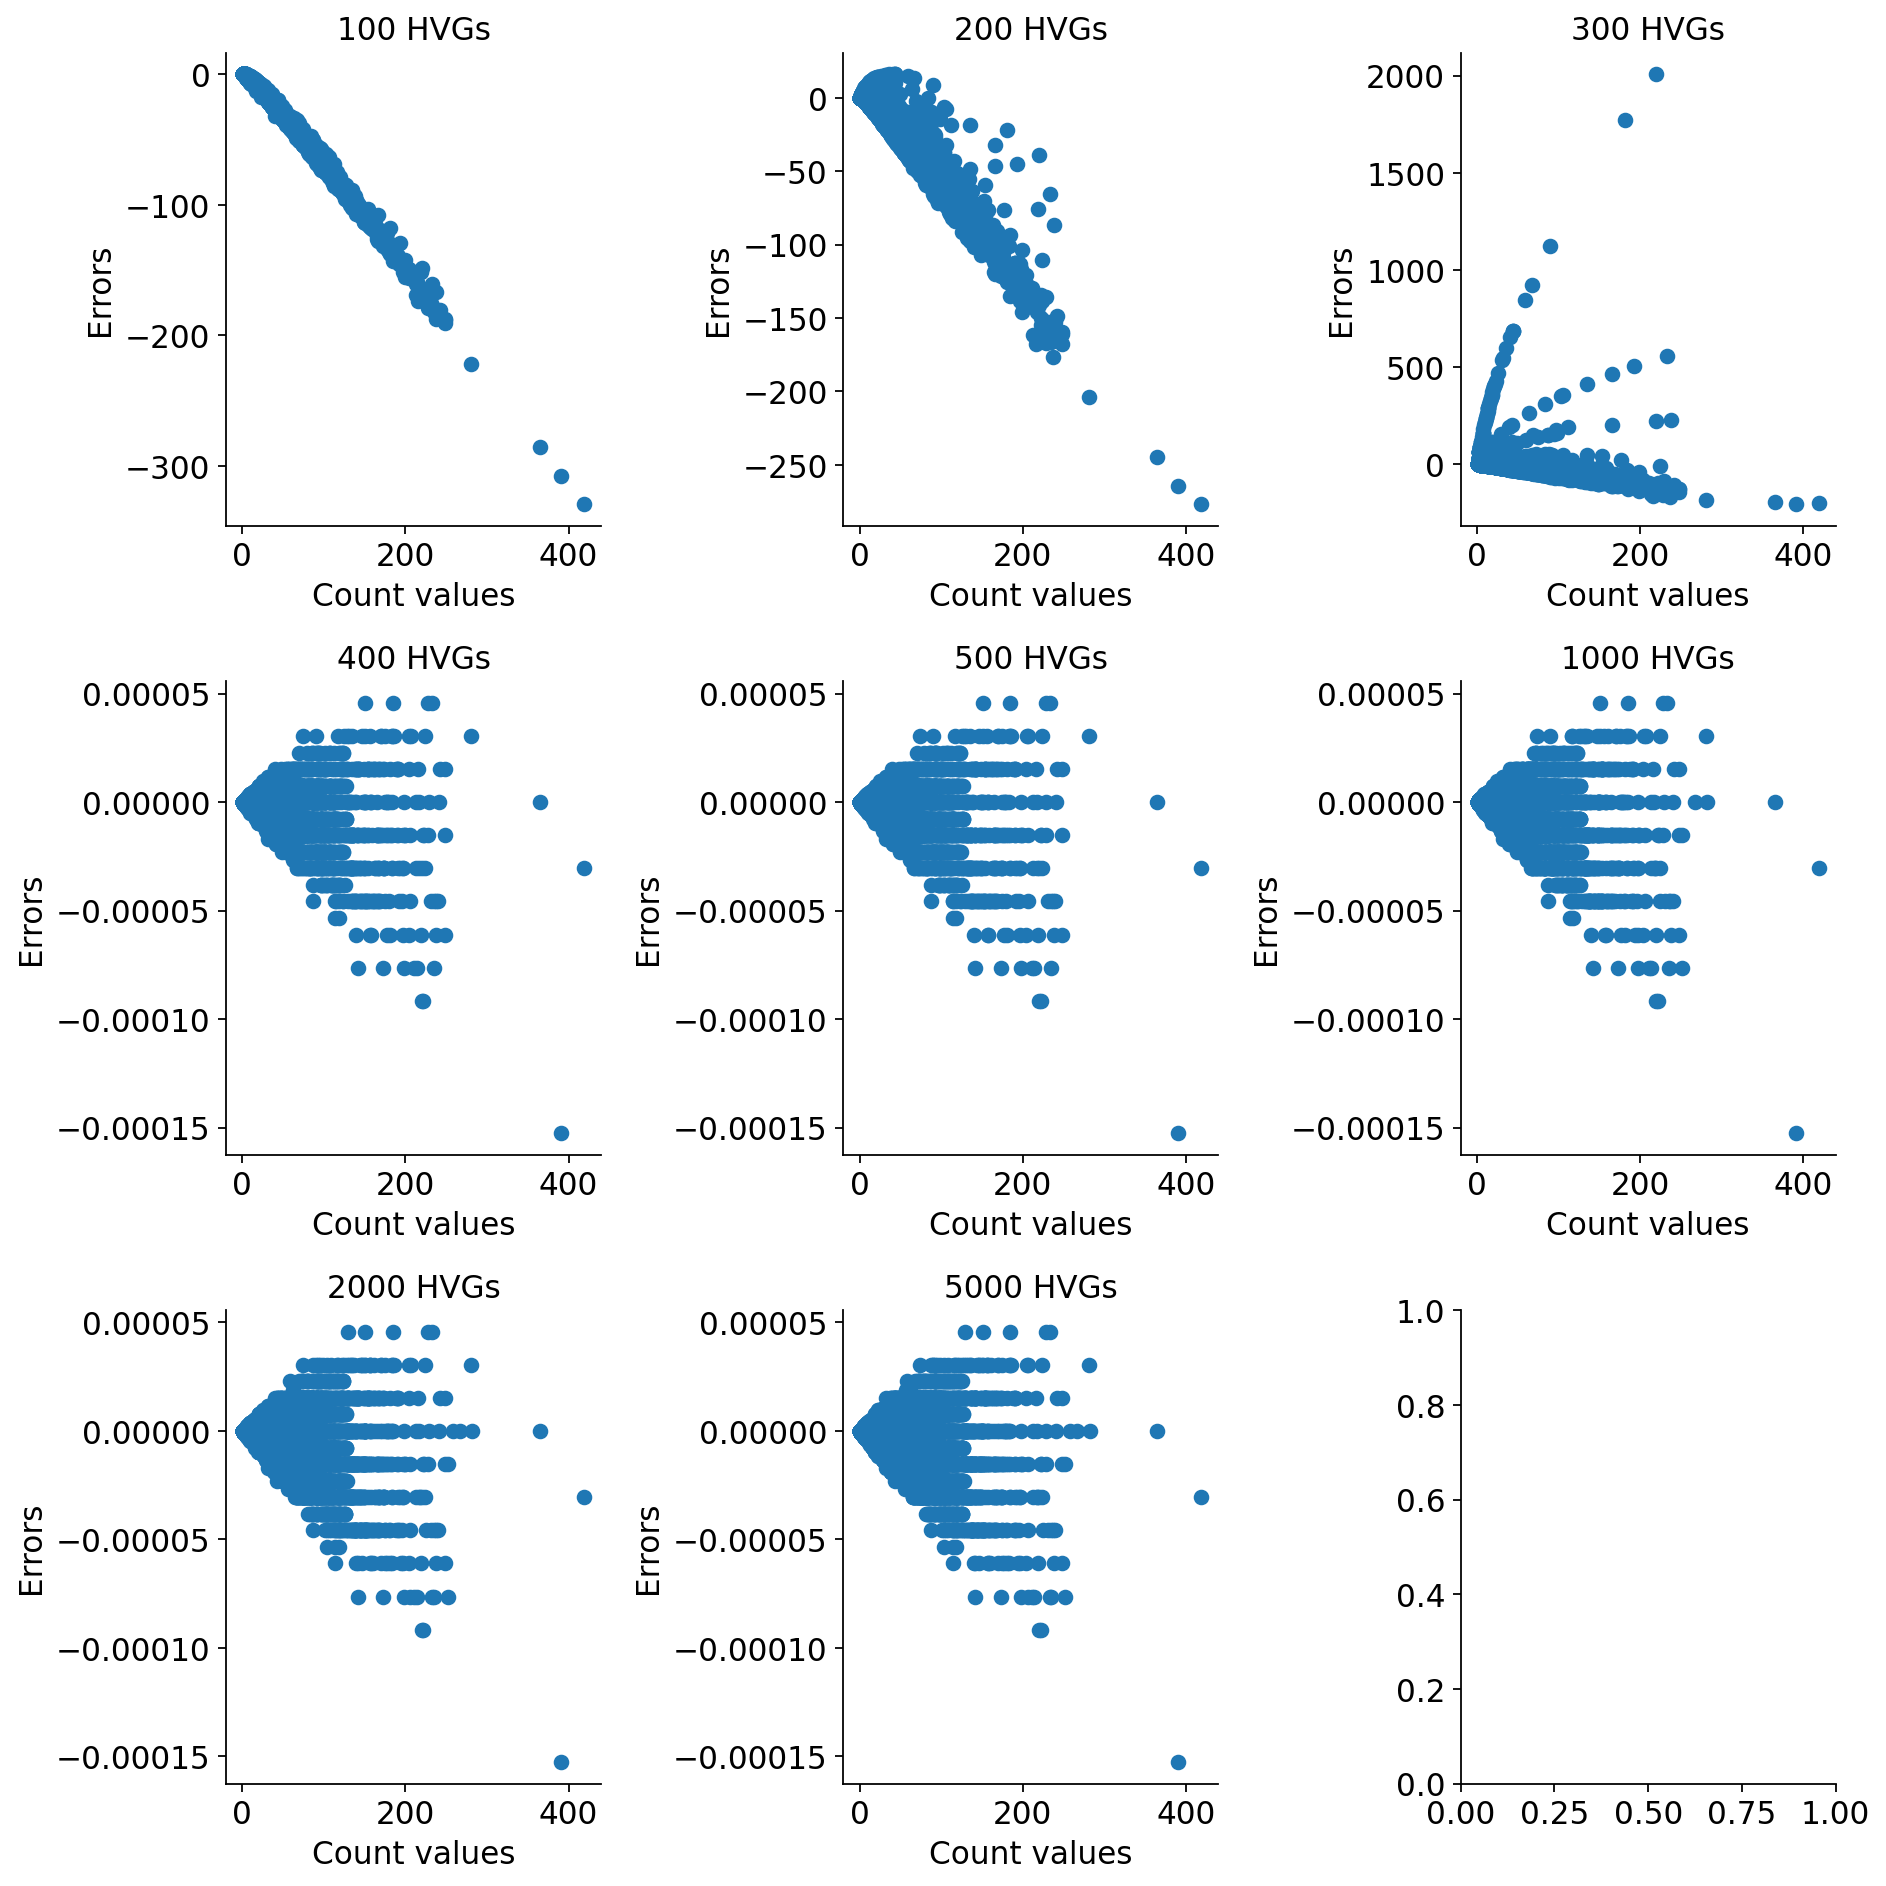

In [ ]:
hvg=[100,200,300,400,500,1000,2000,5000]
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through each subplot and plot the data
for i in range(3):
    for j in range(3):
        try:
            ax = axs[i, j]
            ax.plot(hh_ad[i*3+j].layers['count'].data, hh_res[i*3+j], 'o')
            ax.grid(visible=False)
            ax.set_xlabel('Count values')
            ax.set_ylabel('Errors')
            ax.set_title(str(hvg[i*3+j])+' HVGs')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        except:
            pass

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()